# Feature set 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])


In [3]:
def data_processor_cnn(X_folds,Y_folds):
    Y_folds=([to_categorical(Y_folds, num_classes=10) for Y_folds in Y_folds])
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6))
    return X_folds,Y_folds

In [4]:
def data_processor_basic_nn(X_fold,Y_folds):
    for i in range(0, len(Y_folds)):
        Y_folds[i]=np.reshape(Y_folds[i],(Y_folds[i].shape[0], 1))
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6))
    return X_folds,Y_folds

In [5]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [6]:
Data_Linear=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_Linear[0]
Y_folds_1=Data_Linear[1]

#### Shapes of the data


In [7]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))

X_data 1 = (873, 40, 6)
Y_data 1 = (873, 10)
X_data 2 = (888, 40, 6)
Y_data 2 = (888, 10)
X_data 3 = (925, 40, 6)
Y_data 3 = (925, 10)
X_data 4 = (990, 40, 6)
Y_data 4 = (990, 10)
X_data 5 = (936, 40, 6)
Y_data 5 = (936, 10)
X_data 6 = (823, 40, 6)
Y_data 6 = (823, 10)
X_data 7 = (838, 40, 6)
Y_data 7 = (838, 10)
X_data 8 = (806, 40, 6)
Y_data 8 = (806, 10)
X_data 9 = (816, 40, 6)
Y_data 9 = (816, 10)
X_data 10 = (837, 40, 6)
Y_data 10 = (837, 10)


## Defining Functions

## Simple nn models as function

In [8]:
def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [9]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph plotting function

In [10]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Val_Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table making function

In [11]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [12]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Models

### Model 1

In [13]:
model=Sequential()
model.add(Flatten(input_shape=[40, 6]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [14]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]

Epoch_number=50
Batch_size=30


Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6) (7859, 1) (873, 40, 6) (873, 1)
Accuracy of Fold 1 is 0.7231403589248657
Time to train Fold 1 : 42.7322 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6) (7844, 1) (888, 40, 6) (888, 1)
Accuracy of Fold 2 is 0.8587735891342163
Time to train Fold 2 : 40.4651 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6) (7807, 1) (925, 40, 6) (925, 1)
Accuracy of Fold 3 is 0.8934571743011475
Time to train Fold 3 : 40.5564 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6) (7742, 1) (990, 40, 6) (990, 1)
Accuracy of Fold 4 is 0.9037690758705139
Time to train Fold 4 : 39.8363 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6) (7796, 1) (936, 40, 6) (936, 1)
Accuracy of Fold 5 is 0.9107542634010315
Time to train Fold 5 : 39.4048 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6) (7909, 1) (823, 40, 6) (823, 1)
Accuracy of Fold 6 is 0.9

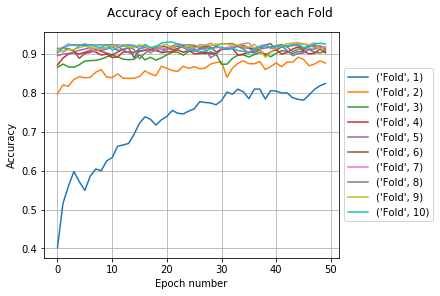

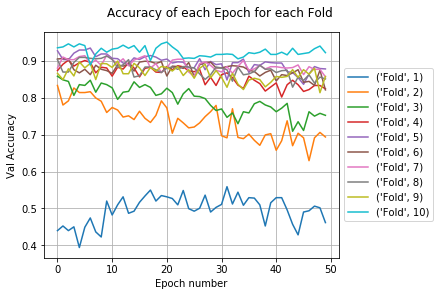

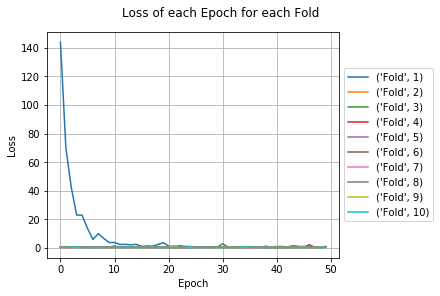

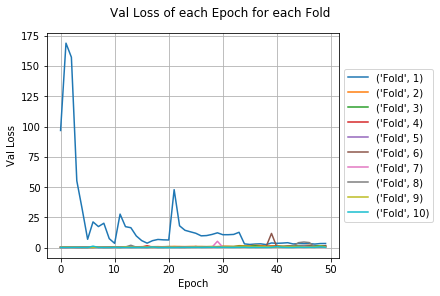

In [15]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array)

In [16]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.723140     42.7322
1    2  0.858774     40.4651
2    3  0.893457     40.5564
3    4  0.903769     39.8363
4    5  0.910754     39.4048
5    6  0.913023     46.6324
6    7  0.919179     99.0409
7    8  0.916217     40.8019
8    9  0.918583     41.4442
9   10  0.918280     41.1250

    Average Accuracy  Total Time
0          0.887518    472.0392


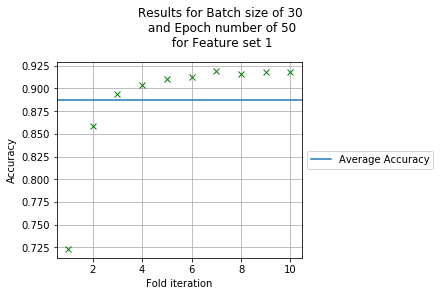

In [17]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

# Model 2

In [18]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(40,6,1)))
model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)
Accuracy of Fold 1 is 0.7832149267196655
Time to train Fold 1 : 70.023 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.8299548625946045
Time to train Fold 2 : 59.9998 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.8642319440841675
Time to train Fold 3 : 55.292 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.8814867734909058
Time to train Fold 4 : 56.1958 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.8859972953796387
Time to train Fold 5 : 55.2984 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (823,

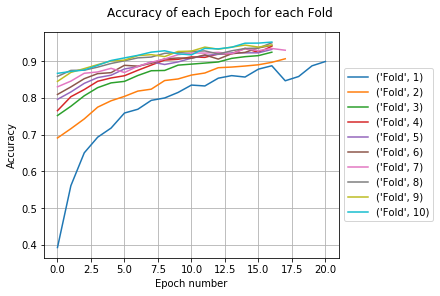

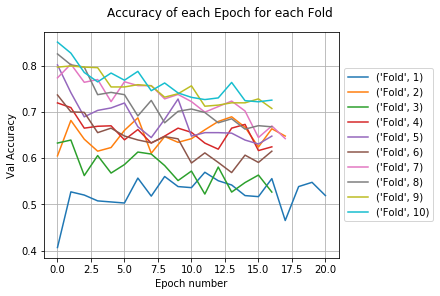

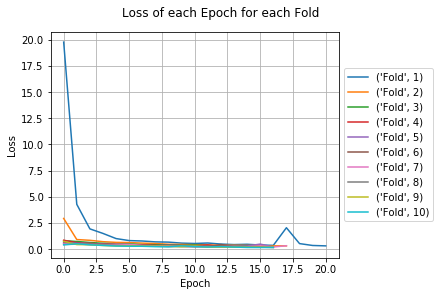

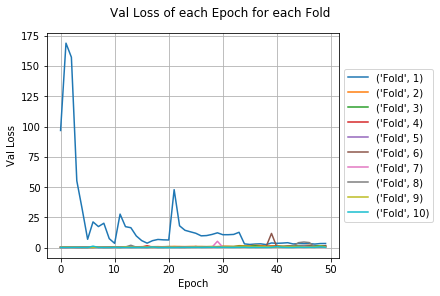

In [20]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2) 

In [21]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.783215     70.0230
1    2  0.829955     59.9998
2    3  0.864232     55.2920
3    4  0.881487     56.1958
4    5  0.885997     55.2984
5    6  0.892074     53.8709
6    7  0.899199     58.4606
7    8  0.910310     55.3992
8    9  0.913102     54.4915
9   10  0.916291     56.2127

    Average Accuracy  Total Time
0          0.877586    575.2439


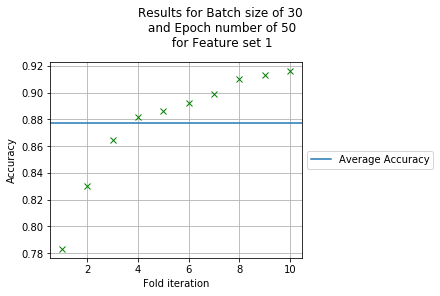

In [22]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

## Model 3

In [23]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [24]:
Accuracy_array_3=[]
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)
Accuracy of Fold 1 is 0.4091614782810211
Time to train Fold 1 : 191.5425 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.45396479964256287
Time to train Fold 2 : 94.3412 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.5428034663200378
Time to train Fold 3 : 97.2128 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.5972545146942139
Time to train Fold 4 : 84.3578 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.6125458478927612
Time to train Fold 5 : 125.1765 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) 

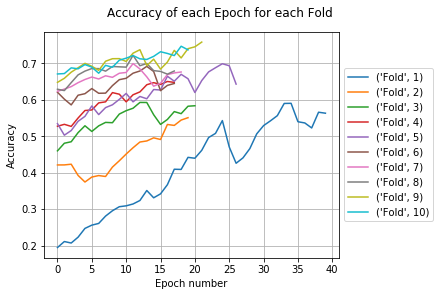

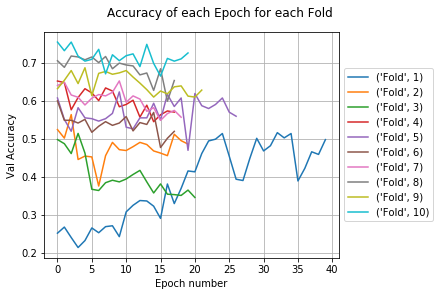

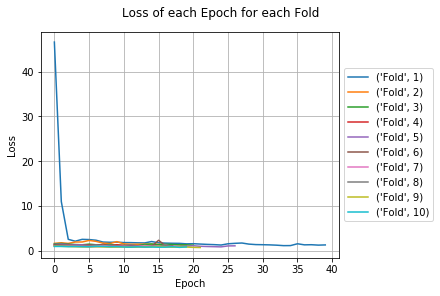

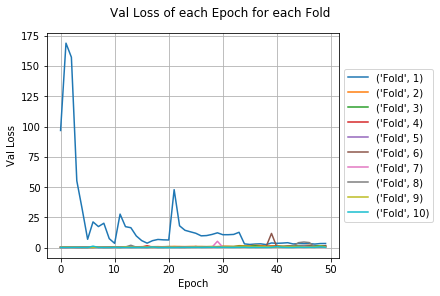

In [25]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3) 

In [26]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.409161    191.5425
1    2  0.453965     94.3412
2    3  0.542803     97.2128
3    4  0.597255     84.3578
4    5  0.612546    125.1765
5    6  0.637733     82.9370
6    7  0.659208     89.4792
7    8  0.676767     83.3955
8    9  0.705424   2098.9401
9   10  0.704864     84.6566

    Average Accuracy  Total Time
0          0.599973   3032.0392


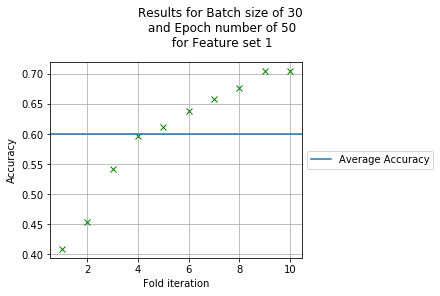

In [27]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

## Model 4

In [33]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [34]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Model_4=Model_run_nn(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)
Accuracy of Fold 1 is 0.7595750689506531
Time to train Fold 1 : 152.9894 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.8713386654853821
Time to train Fold 2 : 148.1711 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.9028384685516357
Time to train Fold 3 : 158.5705 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.9198527336120605
Time to train Fold 4 : 150.4414 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.9313390851020813
Time to train Fold 5 : 160.5276 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10

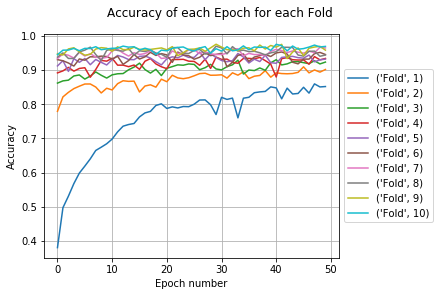

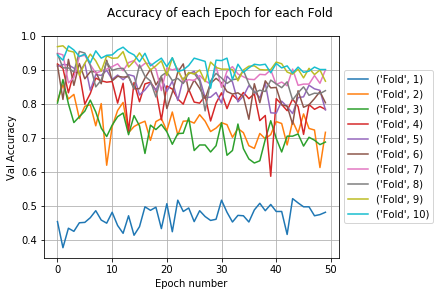

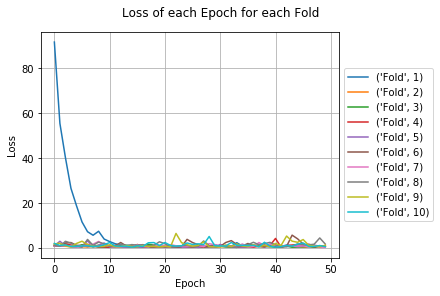

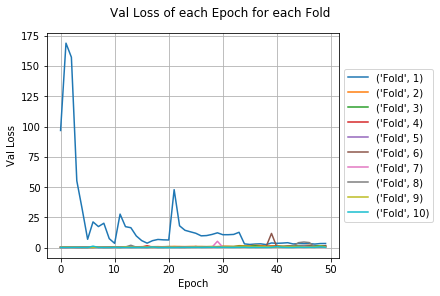

In [35]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4) 

In [36]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.759575    152.9894
1    2  0.871339    148.1711
2    3  0.902838    158.5705
3    4  0.919853    150.4414
4    5  0.931339    160.5276
5    6  0.937016    179.3642
6    7  0.949078    180.6470
7    8  0.952677    170.5478
8    9  0.959816    167.2242
9   10  0.962452    176.2947

    Average Accuracy  Total Time
0          0.914598   1644.7779


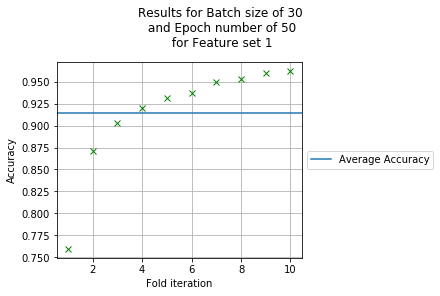

In [37]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

## Model Comparisson

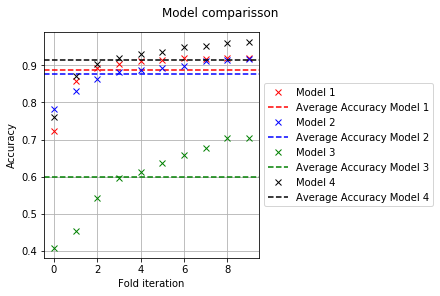

In [39]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")

ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")

ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")

ax1.plot(Fold_accuracy_4,"kx",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='k',ls="--")

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))